In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_path = '/content/drive/MyDrive/Colab Notebooks/Coord_data/'

In [54]:
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, ReLU, LocallyConnected2D, Conv2DTranspose, Flatten, Softmax, GlobalAvgPool2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Dense
batch_size = 64
x_dim = 64
y_dim = 64
filename = drive_path + "rectangle_4_uniform.h5"
h5_file = h5py.File(filename, 'r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2368, 64, 64, 3)
(2368, 64, 64, 1)


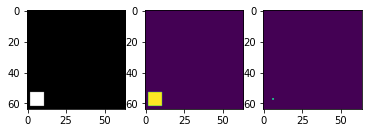

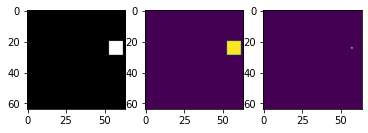

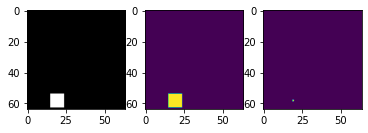

In [55]:
train_image = np.array(h5_file['train_image'])
train_imagegray = np.array(h5_file['train_imagegray'])
train_onehots = np.array(h5_file['train_onehots'])

print(train_image.shape)
print(train_imagegray.shape)

for idx in range(3):
    plt.figure()
    plt.subplot(131)
    plt.imshow(train_image[idx, :, :, :])
    plt.subplot(132)
    plt.imshow(train_imagegray[idx, :, :, 0]/255)
    plt.subplot(133)
    plt.imshow(train_onehots[idx, :, :, 0])
plt.show()


**Classification Model**

In [87]:
train_x = np.array(h5_file['train_locations'], dtype=int)  # shape (2407, 2)
train_y = np.array(h5_file['train_onehots'], dtype=float)  # shape (2407, 64, 64, 1)
test_x = np.array(h5_file['val_locations'], dtype=float)  # shape (729, 2)
test_y = np.array(h5_file['val_onehots'], dtype=float)  # shape (729, 64, 64, 1)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2368, 2)
(2368, 64, 64, 1)
(768, 2)
(768, 64, 64, 1)


In [88]:
def add_coords(input_tensor):
  x_dim = input_tensor.shape[1]
  y_dim = input_tensor.shape[2]
  tensor_batch_size = tf.shape(input_tensor)[0]  # batch size
  x_ones = tf.ones([tensor_batch_size, x_dim], dtype=tf.int32)    # (batch, 64)
  x_ones = tf.expand_dims(x_ones, -1)                   # (batch, 64, 1)
  x_range = tf.tile(tf.expand_dims(tf.range(x_dim), 0), [tensor_batch_size, 1])  # (batch, 64)

  x_range = tf.expand_dims(x_range, 1)                  # (batch, 1, 64)

  x_channel = tf.matmul(x_ones, x_range)               # (batch, 64, 64)
  x_channel = tf.expand_dims(x_channel, -1)             # (batch, 64, 64, 1)

  y_ones = tf.ones([tensor_batch_size, y_dim], dtype=tf.int32)   # (batch, 64)
  y_ones = tf.expand_dims(y_ones, 1)                    # (batch, 1, 64)
  y_range = tf.tile(tf.expand_dims(tf.range(x_dim), 0), [tensor_batch_size, 1])   # (batch, 64)
  y_range = tf.expand_dims(y_range, -1)                 # (batch, 64, 1)

  y_channel = tf.matmul(y_range, y_ones)               # (batch, 64, 64)
  y_channel = tf.expand_dims(y_channel, -1)             # (batch, 64, 64, 1)

  x_channel = tf.cast(x_channel, 'float32') / (x_dim - 1)
  y_channel = tf.cast(y_channel, 'float32') / (y_dim - 1)
  x_channel = x_channel * 2 - 1    
  y_channel = y_channel * 2 - 1
    
  ret = tf.concat([input_tensor, 
                    x_channel, 
                    y_channel], axis=-1)    # (batch, 64, 64, c+2)
  
  return ret

In [89]:
def tile(input_tensor):  # (1, 1, 2)
  input_tensor = tf.tile(input_tensor, [1, 64, 64, 1]) # (batch, 64, 64, 2)
  input_tensor = tf.cast(input_tensor, 'float32')
  return input_tensor

In [90]:
class TilingLayer(tf.keras.layers.Layer):
  def __init__(self):
    super(TilingLayer, self).__init__()

  def build(self, input_shape):
    # print("IN BUILD")
    pass

  def call(self, input_tensor):
    # print("IN CALL")
    input_tensor /= 64
    ret = tile(input_tensor)
    return ret

In [91]:
class CoordConv(tf.keras.layers.Layer):
  def __init__(self, filters, kernel_size):
    super(CoordConv, self).__init__()
    self.conv_layer = Conv2D(filters, kernel_size, padding="same", kernel_initializer=he_normal, kernel_regularizer='l2')

  def build(self, input_shape):
    # print("IN BUILD")
    pass

  def call(self, input_tensor):
    # print("IN CALL")
    ret = add_coords(input_tensor)
    ret = self.conv_layer(ret);
    return ret

In [12]:
def deconv_block(filters, kernel_size, dropout=False):
  model = Sequential()
  model.add(Conv2DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=he_normal, kernel_regularizer='l2'))
  model.add(BatchNormalization(momentum=0.9, epsilon=1e-5))

  if dropout:
    model.add(Dropout(0.5))

  model.add(ReLU())
  return model

In [92]:
def conv_block(filters, kernel_size, dropout=False, set_strides=1, add_batch=False):
  model = Sequential()
  model.add(Conv2D(filters, kernel_size, strides=set_strides, padding='same', kernel_initializer=he_normal, kernel_regularizer='l2'))
  if add_batch:
    model.add(BatchNormalization(momentum=0.9, epsilon=1e-5))
  if dropout:
    model.add(Dropout(0.5))

  model.add(ReLU())
  return model

In [50]:
# Classification model-without CoordConv
def Model():
  inputs = tf.keras.layers.Input(shape=[1, 1, 2])
  layers = [
    deconv_block(64, 3, dropout=True),   # (2, 2, 64)
   
    deconv_block(64, 3),  # (4, 4, 64)
  
    deconv_block(64, 3),  # (8, 8, 64)      
   
    deconv_block(32, 3),  # (16, 16, 32)
    
    deconv_block(32, 3),   # (32, 32, 32)
    
    deconv_block(1, 3),  # (64, 64, 1)
  ]

  x = inputs

  for layer in layers:
    x = layer(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

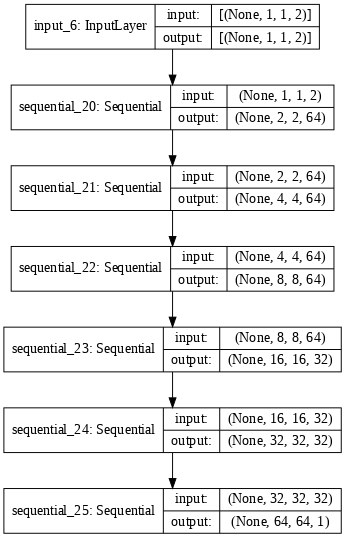

In [51]:
model = Model()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [93]:
# Classification model-with CoordConv

def Model():
  inputs = tf.keras.layers.Input(shape=[1, 1, 2])
  layers = [
    TilingLayer(),   # (64, 64, 2)

    CoordConv(64, 1),  # (64, 64, 64)
    ReLU(),

    conv_block(32, 1),  # (64, 64, 32)      

    conv_block(64, 1),  # (64, 64, 32)

    conv_block(64, 1),  # (64, 64, 32)

    conv_block(1, 1)  # (64, 64, 1)
  ]

  x = inputs

  for layer in layers:
    x = layer(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

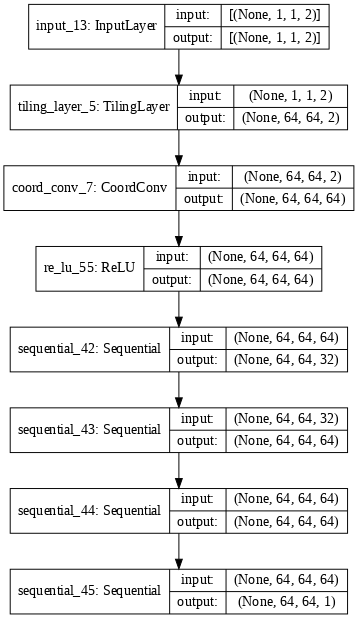

In [94]:
model = Model()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [95]:
# Classification model loss
def loss_cls(model, coord_batch, labels_flat):
  model_output = model(coord_batch)
  logits_flat = Flatten()(model_output)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_flat, labels=labels_flat))
  return loss

model_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [96]:
def train(loss, model, opt, input_batch, labels_flat):
  with tf.GradientTape() as tape:
    gradients = tape.gradient(loss(model, input_batch, labels_flat), model.trainable_variables)
  gradient_variables = zip(gradients, model.trainable_variables)
  opt.apply_gradients(gradient_variables)

In [99]:
epochs = 10
batch_count = int((train_x.shape[0] - 1) / batch_size) + 1
for epoch in range(epochs):
  start = time.time()
  print("epoch ", epoch, "of", str(epochs))
  for batch in range(batch_count):
    if batch == batch_count - 1:
        coord_batch = train_x[batch * batch_size:]
        labels_batch = train_y[batch * batch_size:]
    else:
        coord_batch = train_x[batch * batch_size: (batch + 1) * batch_size]
        labels_batch = train_y[batch * batch_size: (batch + 1) * batch_size]
    if batch % 10 == 0:
      print("batch:", batch, ",", end =" ")
    coord_batch = coord_batch.reshape((coord_batch.shape[0], 1, 1, coord_batch.shape[1]))

    model_output = model(coord_batch)  # (64, 64, 64, 1)
    logits_flat = Flatten()(model_output)   # (64, 4096)
    labels_flat = Flatten()(labels_batch)   # (64, 4096)
    train(loss_cls, model, model_optimizer, coord_batch, labels_flat)
    loss_value = loss_cls(model, coord_batch, labels_flat)
    if batch % 10 == 0:
      print("Loss is: ", loss_value.numpy())
  print("TIME TAKEN FOR EPOCH: ", time.time()-start)
  print("************")

epoch  0 of 10
batch: 0 , Loss is:  0.8373772
batch: 10 , Loss is:  0.8397893
batch: 20 , Loss is:  0.79787767
batch: 30 , Loss is:  0.784789
TIME TAKEN FOR EPOCH:  1.7559635639190674
************
epoch  1 of 10
batch: 0 , Loss is:  0.69603276
batch: 10 , Loss is:  0.69580483
batch: 20 , Loss is:  0.669284
batch: 30 , Loss is:  0.6901777
TIME TAKEN FOR EPOCH:  1.733586072921753
************
epoch  2 of 10
batch: 0 , Loss is:  0.5147516
batch: 10 , Loss is:  0.5409625
batch: 20 , Loss is:  0.43196982
batch: 30 , Loss is:  0.5247319
TIME TAKEN FOR EPOCH:  1.7007386684417725
************
epoch  3 of 10
batch: 0 , Loss is:  0.43982375
batch: 10 , Loss is:  0.42713398
batch: 20 , Loss is:  0.34795406
batch: 30 , Loss is:  0.3972301
TIME TAKEN FOR EPOCH:  1.7244081497192383
************
epoch  4 of 10
batch: 0 , Loss is:  0.3547355
batch: 10 , Loss is:  0.3109419
batch: 20 , Loss is:  0.24929464
batch: 30 , Loss is:  0.33104348
TIME TAKEN FOR EPOCH:  1.7235658168792725
************
epoch  5 

Classification Model Testing

In [100]:
batch_count = int((test_x.shape[0] - 1) / batch_size) + 1
for batch in range(batch_count):
  if batch == batch_count - 1:
    coord_batch = test_x[batch * batch_size:]
    labels_batch = test_y[batch * batch_size:]
  else:
    coord_batch = test_x[batch * batch_size: (batch + 1) * batch_size]
    labels_batch = test_y[batch * batch_size: (batch + 1) * batch_size]

  print("batch:", batch, ",", end =" ")
  coord_batch = coord_batch.reshape((coord_batch.shape[0], 1, 1, coord_batch.shape[1]))
  model_output = model(coord_batch)  # (64, 64, 64, 1)
  
  # for i in range(2):
  #   ind = i + 9
  #   outt = tf.reshape(model_output[ind], (64, 64))
  #   plt.imshow(outt)
  #   plt.colorbar()
  #   plt.show()
  #   label_0 = tf.reshape(labels_batch[ind], [labels_batch[ind].shape[0], labels_batch[ind].shape[1]])
  #   plt.imshow(label_0)
  #   plt.colorbar()
  #   plt.show()
  # break
  
  logits_flat = Flatten()(model_output)   # (64, 4096)
  labels_flat = Flatten()(labels_batch)   # (64, 4096)

  loss_value = loss_cls(model, coord_batch, labels_flat)
  print("Loss is: ", loss_value.numpy())

  prob_output = tf.nn.softmax(logits_flat)   # (64, 4096)
  argmax_prob = tf.argmax(prob_output, 1)   # index in [0,64*64)
  argmax_label = tf.argmax(labels_flat, 1)   # index in [0,64*64)
  
  correct = tf.equal(argmax_prob, argmax_label)
  
  accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))
  print("ACCURACY:", accuracy)

batch: 0 , Loss is:  0.2590616
ACCURACY: tf.Tensor(0.890625, shape=(), dtype=float32)
batch: 1 , Loss is:  0.40213513
ACCURACY: tf.Tensor(0.78125, shape=(), dtype=float32)
batch: 2 , Loss is:  0.19285457
ACCURACY: tf.Tensor(0.953125, shape=(), dtype=float32)
batch: 3 , Loss is:  0.3298331
ACCURACY: tf.Tensor(0.84375, shape=(), dtype=float32)
batch: 4 , Loss is:  0.31300533
ACCURACY: tf.Tensor(0.90625, shape=(), dtype=float32)
batch: 5 , Loss is:  0.31679004
ACCURACY: tf.Tensor(0.875, shape=(), dtype=float32)
batch: 6 , Loss is:  0.28749028
ACCURACY: tf.Tensor(0.859375, shape=(), dtype=float32)
batch: 7 , Loss is:  0.29832155
ACCURACY: tf.Tensor(0.875, shape=(), dtype=float32)
batch: 8 , Loss is:  0.26790473
ACCURACY: tf.Tensor(0.90625, shape=(), dtype=float32)
batch: 9 , Loss is:  0.38685337
ACCURACY: tf.Tensor(0.828125, shape=(), dtype=float32)
batch: 10 , Loss is:  0.46562818
ACCURACY: tf.Tensor(0.796875, shape=(), dtype=float32)
batch: 11 , Loss is:  0.36743125
ACCURACY: tf.Tensor(0

**Regression Model**

In [77]:
train_x = np.array(h5_file['train_onehots'], dtype=float)
train_y = np.array(h5_file['train_normalized_locations'], dtype=float) 
test_x = np.array(h5_file['val_onehots'], dtype=float) 
test_y = np.array(h5_file['val_normalized_locations'], dtype=float)  

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2368, 64, 64, 1)
(2368, 2)
(768, 64, 64, 1)
(768, 2)


In [78]:
# Regression model loss
def loss_reg(model, image_batch, labels_flat):
  model_output = model(image_batch)
  logits_flat = Flatten()(model_output)
  loss = tf.reduce_mean(tf.pow(logits_flat - labels_flat, 2))
  return loss

model_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [79]:
# Regression model-without CoordConv

def Model_Regressor():
  inputs = tf.keras.layers.Input(shape=[64, 64, 1])
  layers = [
    conv_block(64, 3, dropout=True, set_strides=2, add_batch=True),   # (32, 32, 64)
   
    conv_block(64, 3, set_strides=2, add_batch=True),  # (16, 16, 64)
  
    conv_block(64, 3, set_strides=2, add_batch=True),  # (8, 8, 64)      
   
    conv_block(32, 3, set_strides=2, add_batch=True),  # (4, 4, 32)
    
    conv_block(32, 3, set_strides=2, add_batch=True),   # (2, 2, 32)
    
    conv_block(2, 3, set_strides=2, add_batch=True),  # (1, 1, 2)
  ]

  x = inputs

  for layer in layers:
    x = layer(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

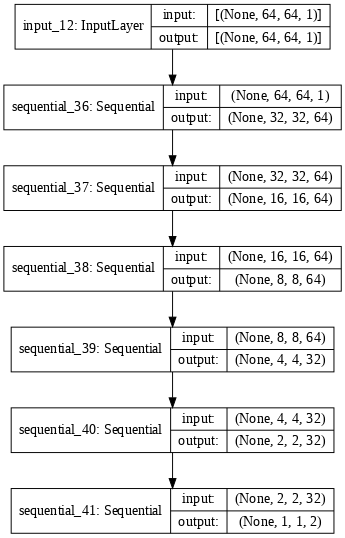

In [80]:
model_r = Model_Regressor()
tf.keras.utils.plot_model(model_r, show_shapes=True, dpi=70)
WITH_COORD = False

In [16]:
# Regression model-with CoordConv
def Model_Regressor():
  inputs = tf.keras.layers.Input(shape=[64, 64, 1])
  layers = [
    CoordConv(8, 1),   # (64, 64, 8)
   
    conv_block(8, 1),  # (64, 64, 8)
  
    conv_block(8, 1),  # (64, 64, 8)      
   
    conv_block(8, 3),  # (64, 64, 8)
    
    conv_block(2, 3),  # (64, 64, 2)

    GlobalAveragePooling2D(),
  ]

  x = inputs

  for layer in layers:
    x = layer(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

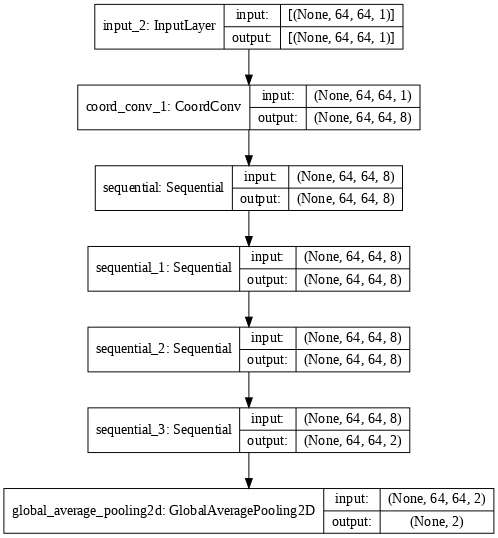

In [17]:
model_r = Model_Regressor()
tf.keras.utils.plot_model(model_r, show_shapes=True, dpi=70)
WITH_COORD = True

In [81]:
epochs = 30
batch_count = int((train_x.shape[0] - 1) / batch_size) + 1
for epoch in range(epochs):
  start = time.time()
  print("epoch ", epoch, "of", str(epochs))
  for batch in range(batch_count):
    if batch == batch_count - 1:
        image_batch = train_x[batch * batch_size:]
        labels_batch = train_y[batch * batch_size:]
    else:
        image_batch = train_x[batch * batch_size: (batch + 1) * batch_size]
        labels_batch = train_y[batch * batch_size: (batch + 1) * batch_size]
    if batch % 10 == 0:
      print("batch:", batch, ",", end =" ")
    model_output = model_r(image_batch)  # (64, 64, 64, 1)
    logits_flat = Flatten()(model_output)   # (64, 4096)
    labels_flat = Flatten()(labels_batch)   # (64, 4096)
    train(loss_reg, model_r, model_optimizer, image_batch, labels_flat)
    loss_value = loss_reg(model_r, image_batch, labels_flat)
    if batch % 10 == 0:
      print("Loss is: ", loss_value.numpy())
  print("TIME TAKEN FOR EPOCH: ", time.time()-start)
  print("************")

epoch  0 of 30
batch: 0 , Loss is:  0.30727035
batch: 10 , Loss is:  0.055036236
batch: 20 , Loss is:  0.017658608
batch: 30 , Loss is:  0.008890195
TIME TAKEN FOR EPOCH:  1.416135311126709
************
epoch  1 of 30
batch: 0 , Loss is:  0.0069869775
batch: 10 , Loss is:  0.003314199
batch: 20 , Loss is:  0.002287058
batch: 30 , Loss is:  0.0012484549
TIME TAKEN FOR EPOCH:  1.3509635925292969
************
epoch  2 of 30
batch: 0 , Loss is:  0.00082533923
batch: 10 , Loss is:  0.0009313966
batch: 20 , Loss is:  0.0006833372
batch: 30 , Loss is:  0.0005627749
TIME TAKEN FOR EPOCH:  1.364882230758667
************
epoch  3 of 30
batch: 0 , Loss is:  0.00038784364
batch: 10 , Loss is:  0.000396714
batch: 20 , Loss is:  0.00039241544
batch: 30 , Loss is:  0.00029746836
TIME TAKEN FOR EPOCH:  1.3504681587219238
************
epoch  4 of 30
batch: 0 , Loss is:  0.00021992711
batch: 10 , Loss is:  0.00024310045
batch: 20 , Loss is:  0.00025078916
batch: 30 , Loss is:  0.0002141105
TIME TAKEN FO

Testing

In [82]:
batch_count = int((test_x.shape[0] - 1) / batch_size) + 1
for batch in range(batch_count):
  if batch == batch_count - 1:
    image_batch = test_x[batch * batch_size:]
    labels_batch = test_y[batch * batch_size:]
  else:
    image_batch = test_x[batch * batch_size: (batch + 1) * batch_size]
    labels_batch = test_y[batch * batch_size: (batch + 1) * batch_size]

  print("batch:", batch, ",", end =" ")
  # print(image_batch.shape)
  model_output = model_r(image_batch)  # (64, 64, 64, 1)
  
  # for i in range(2):
  #   ind = i + 9
  #   outt = tf.reshape(image_batch[ind], (64, 64))
  #   plt.imshow(outt)
  #   plt.colorbar()
  #   plt.show()
  #   label_0 = model_output[ind] * 64
  #   print(label_0)
  # break
  
  logits_flat = Flatten()(model_output)   # (64, 4096)
  labels_flat = Flatten()(labels_batch)   # (64, 4096)

  loss_value = loss_reg(model_r, image_batch, labels_flat)
  print("Loss is: ", loss_value.numpy())
  

batch: 0 , Loss is:  0.00019085775
batch: 1 , Loss is:  0.00017051167
batch: 2 , Loss is:  0.00012388983
batch: 3 , Loss is:  0.00012936397
batch: 4 , Loss is:  0.00018516966
batch: 5 , Loss is:  0.00016440186
batch: 6 , Loss is:  0.00012667311
batch: 7 , Loss is:  0.00012366177
batch: 8 , Loss is:  0.00020286042
batch: 9 , Loss is:  0.00015246413
batch: 10 , Loss is:  0.00018823796
batch: 11 , Loss is:  0.00012812998


Output Visualization

(768, 64, 64, 1)
(768, 2)


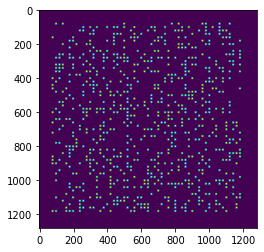

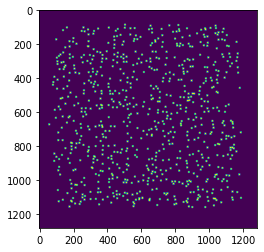

In [85]:
def add_to_image(new_data, image):
    point_x = new_data[0] * 64
    point_y = new_data[1] * 64

    image_x = int(point_x * granularity)
    image_y = int(point_y * granularity)

    image[image_x - dot_radius: image_x + dot_radius, image_y - dot_radius: image_y + dot_radius] = 1

    for i in range(-dot_radius, dot_radius):
      for j in range(-dot_radius, dot_radius):
        image[int(point_x * granularity) + i, int(point_y * granularity) + j] = 1

def visualize_regression_output(data, labels):
  prediction_image = np.zeros((granularity * 64, granularity * 64))
  labels_image = np.zeros((granularity * 64, granularity * 64))

  batch_count = int((data.shape[0] - 1) / batch_size) + 1
  for batch in range(batch_count):
    if batch == batch_count - 1:
      image_batch = data[batch * batch_size:]
      labels_batch = labels[batch * batch_size:]
    else:
      image_batch = data[batch * batch_size: (batch + 1) * batch_size]
      labels_batch = labels[batch * batch_size: (batch + 1) * batch_size]

    model_output = model_r(image_batch)
    if not WITH_COORD:
      model_output = tf.reshape(model_output, (-1, 2))
    for batch_index in range(len(image_batch)):
      add_to_image(model_output[batch_index], prediction_image)
      add_to_image(labels_batch[batch_index], labels_image)

  plt.imshow(labels_image)
  plt.show()
  plt.imshow(prediction_image)
  plt.show()

granularity = 20
dot_radius = 5
print(test_x.shape)
print(test_y.shape)

visualize_regression_output(test_x, test_y)

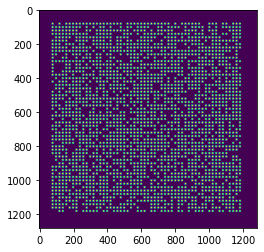

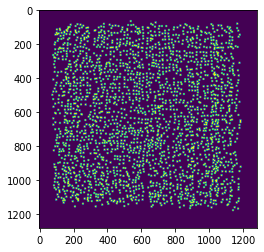

In [86]:
visualize_regression_output(train_x, train_y)